Deep Learning
=============

Assignment 3
------------

Previously in `2_fullyconnected.ipynb`, you trained a logistic regression and a neural network model.

The goal of this assignment is to explore regularization techniques.

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle

First reload the data we generated in _notmist.ipynb_.

In [3]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (400000, 28, 28) (400000,)
Validation set (20000, 28, 28) (20000,)
Test set (15000, 28, 28) (15000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 2 to [0.0, 1.0, 0.0 ...], 3 to [0.0, 0.0, 1.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (400000, 784) (400000, 10)
Validation set (20000, 784) (20000, 10)
Test set (15000, 784) (15000, 10)


In [5]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

---
Problem 1
---------

Introduce and tune L2 regularization for both logistic and neural network models. Remember that L2 amounts to adding a penalty on the norm of the weights to the loss. In TensorFlow, you can compute the L2 loss for a tensor `t` using `nn.l2_loss(t)`. The right amount of regularization should improve your validation / test accuracy.

---

In [6]:
np.random.seed(1337)
batch_size = 128
hidden_nodes = 2048
regularization = 0.0000001

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))


  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden = tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1)
  logits = tf.matmul(hidden, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + tf.nn.l2_loss(logits) * regularization
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)

In [27]:
num_steps = 40001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 601.861450
Minibatch accuracy: 10.9%
Validation accuracy: 32.4%
Minibatch loss at step 1000: 28.121788
Minibatch accuracy: 74.2%
Validation accuracy: 81.4%
Minibatch loss at step 2000: 10.545779
Minibatch accuracy: 80.5%
Validation accuracy: 82.8%
Minibatch loss at step 3000: 15.521986
Minibatch accuracy: 77.3%
Validation accuracy: 80.1%
Minibatch loss at step 4000: 10.314809
Minibatch accuracy: 83.6%
Validation accuracy: 83.8%
Minibatch loss at step 5000: 5.474394
Minibatch accuracy: 82.8%
Validation accuracy: 82.0%
Minibatch loss at step 6000: 5.221628
Minibatch accuracy: 85.2%
Validation accuracy: 82.4%
Minibatch loss at step 7000: 2.061932
Minibatch accuracy: 86.7%
Validation accuracy: 84.8%
Minibatch loss at step 8000: 3.527903
Minibatch accuracy: 82.8%
Validation accuracy: 85.0%
Minibatch loss at step 9000: 1.748370
Minibatch accuracy: 84.4%
Validation accuracy: 84.8%
Minibatch loss at step 10000: 1.202536
Minibatch accuracy: 87.5%
Validation

---
Problem 2
---------
Let's demonstrate an extreme case of overfitting. Restrict your training data to just a few batches. What happens?

---

In [28]:
num_steps = 40001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (1000 - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 570.019653
Minibatch accuracy: 11.7%
Validation accuracy: 29.5%
Minibatch loss at step 1000: 18.750111
Minibatch accuracy: 93.8%
Validation accuracy: 70.7%
Minibatch loss at step 2000: 0.522184
Minibatch accuracy: 100.0%
Validation accuracy: 64.7%
Minibatch loss at step 3000: 0.272634
Minibatch accuracy: 100.0%
Validation accuracy: 55.2%
Minibatch loss at step 4000: 0.376766
Minibatch accuracy: 100.0%
Validation accuracy: 60.9%
Minibatch loss at step 5000: 0.298442
Minibatch accuracy: 100.0%
Validation accuracy: 59.1%
Minibatch loss at step 6000: 0.268201
Minibatch accuracy: 100.0%
Validation accuracy: 53.8%
Minibatch loss at step 7000: 0.487896
Minibatch accuracy: 100.0%
Validation accuracy: 67.5%
Minibatch loss at step 8000: 0.177544
Minibatch accuracy: 100.0%
Validation accuracy: 51.6%
Minibatch loss at step 9000: 0.470336
Minibatch accuracy: 100.0%
Validation accuracy: 65.3%
Minibatch loss at step 10000: 0.081189
Minibatch accuracy: 100.0%
Vali

---
Problem 3
---------
Introduce Dropout on the hidden layer of the neural network. Remember: Dropout should only be introduced during training, not evaluation, otherwise your evaluation results would be stochastic as well. TensorFlow provides `nn.dropout()` for that, but you have to make sure it's only inserted during training.

What happens to our extreme overfitting case?

---

In [39]:
np.random.seed(1337)
batch_size = 256
hidden_nodes = 4096
regularization = 0.0000001
dropout_keep = 0.8

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))


  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, num_labels]))
  biases_2 = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1), dropout_keep)
  logits = tf.matmul(hidden, weights_2) + biases_2
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + tf.nn.l2_loss(logits) * regularization
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1), weights_2) + biases_2)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1), weights_2) + biases_2)

In [40]:
num_steps = 40001

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 1000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 684.708008
Minibatch accuracy: 13.7%
Validation accuracy: 38.5%
Minibatch loss at step 1000: 38.186295
Minibatch accuracy: 78.1%
Validation accuracy: 82.3%
Minibatch loss at step 2000: 18.860067
Minibatch accuracy: 81.2%
Validation accuracy: 84.0%
Minibatch loss at step 3000: 12.878065
Minibatch accuracy: 87.9%
Validation accuracy: 83.9%
Minibatch loss at step 4000: 6.013530
Minibatch accuracy: 85.9%
Validation accuracy: 86.1%
Minibatch loss at step 5000: 3.748379
Minibatch accuracy: 89.5%
Validation accuracy: 86.1%
Minibatch loss at step 6000: 4.966045
Minibatch accuracy: 87.9%
Validation accuracy: 86.1%
Minibatch loss at step 7000: 4.181520
Minibatch accuracy: 88.3%
Validation accuracy: 85.7%
Minibatch loss at step 8000: 4.150757
Minibatch accuracy: 87.9%
Validation accuracy: 86.4%
Minibatch loss at step 9000: 5.611575
Minibatch accuracy: 84.8%
Validation accuracy: 86.5%
Minibatch loss at step 10000: 4.733109
Minibatch accuracy: 87.1%
Validation 

---
Problem 4
---------

Try to get the best performance you can using a multi-layer model! The best reported test accuracy using a deep network is [97.1%](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html?showComment=1391023266211#c8758720086795711595).

One avenue you can explore is to add multiple layers.

Another one is to use learning rate decay:

    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.5, step, ...)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
 
 ---


In [24]:
from matplotlib import pyplot

In [72]:
batch_size = 64
max_batch_size = 15000

def lerp(a, b, t):
    t = max(min(t, 1), 0)
    return a + t * (b - a)

display(lerp(batch_size, max_batch_size, 50000/100000.))

7532.0

In [84]:
np.random.seed(1337)
hidden_nodes = 1024
hidden_nodes_2 = 1024
batch_size = 2048
max_batch_size = 4096

def lerp(a, b, t):
    t = max(min(t, 1), 0)
    return a + t * (b - a)


regularization = 0.000000000001
dropout_keep = 1

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  learning_rate = tf.placeholder(tf.float32, shape=[])

  weights_1 = tf.Variable(
    tf.truncated_normal([image_size * image_size, hidden_nodes]))
  biases_1 = tf.Variable(tf.zeros([hidden_nodes]))

  weights_2 = tf.Variable(
    tf.truncated_normal([hidden_nodes, hidden_nodes_2]))
  biases_2 = tf.Variable(tf.zeros([hidden_nodes_2]))


  weights_3 = tf.Variable(
    tf.truncated_normal([hidden_nodes_2, num_labels]))
  biases_3 = tf.Variable(tf.zeros([num_labels]))
  


  # Training computation.
  hidden = tf.nn.dropout(tf.nn.relu(tf.matmul(tf_train_dataset, weights_1) + biases_1), dropout_keep)
  hidden_2 = tf.nn.dropout(tf.nn.relu(tf.matmul(hidden, weights_2) + biases_2), dropout_keep)
  logits = tf.matmul(hidden_2, weights_3) + biases_3
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels)) + tf.nn.l2_loss(logits) * regularization
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_valid_dataset, weights_1) + biases_1),weights_2) + biases_2), weights_3) + biases_3)
  test_prediction = tf.nn.softmax(
    tf.matmul(tf.nn.relu(tf.matmul(tf.nn.relu(tf.matmul(tf_test_dataset, weights_1) + biases_1),weights_2) + biases_2), weights_3) + biases_3)


Initialized
Minibatch loss at step 0: 6634.019043
Minibatch accuracy: 9.4%
Validation accuracy: 23.0%
Minibatch loss at step 4000: 1.526056
Minibatch accuracy: 65.0%
Validation accuracy: 63.3%
Minibatch loss at step 8000: 1.050908
Minibatch accuracy: 69.0%
Validation accuracy: 69.7%
Minibatch loss at step 12000: 1.186167
Minibatch accuracy: 71.8%
Validation accuracy: 72.4%
Minibatch loss at step 16000: 0.821448
Minibatch accuracy: 73.5%
Validation accuracy: 75.1%
Minibatch loss at step 20000: 0.716975
Minibatch accuracy: 76.0%
Validation accuracy: 75.9%
Minibatch loss at step 24000: 0.704490
Minibatch accuracy: 77.5%
Validation accuracy: 76.5%
Minibatch loss at step 28000: 0.745552
Minibatch accuracy: 76.6%
Validation accuracy: 77.6%
Minibatch loss at step 32000: 0.701176
Minibatch accuracy: 77.8%
Validation accuracy: 78.0%
Minibatch loss at step 36000: 0.639617
Minibatch accuracy: 78.7%
Validation accuracy: 78.7%
Minibatch loss at step 40000: 0.660003
Minibatch accuracy: 79.0%
Validat

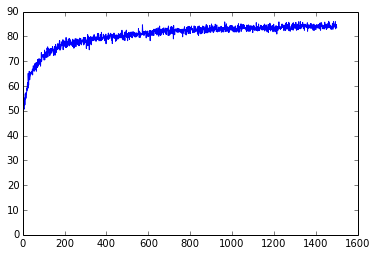

In [85]:
num_steps = 150001

validation_predictions = []

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    current_batch_size = int(lerp(batch_size, max_batch_size, step/float(num_steps)))
    offset = (step * current_batch_size) % (train_labels.shape[0] - current_batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    learning_rate_value = lerp(0.045, 0.001, step/float(num_steps))
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, learning_rate: learning_rate_value}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 100 == 0):
      validation_predictions.append(accuracy(predictions, batch_labels))
    if (step % 4000 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))
  pyplot.plot(np.arange(len(validation_predictions)), validation_predictions)

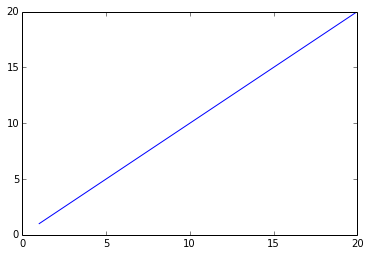

In [36]:
a=[1,5,10,20]
%matplotlib inline
from IPython.display import display, Image
pyplot.plot(a, a)